# Introduction  

The CICIDS2017 dataset is a rich collection of network traffic data that serves as a valuable resource for the evaluation of intrusion detection systems. As part of this analysis, this notebook focuses on cleaning and transforming the CICIDS2017 dataset to make it suitable for training machine learning (ML) models.   

While the initial analysis of the dataset involved exploratory data analysis (EDA) to better understand its structure and characteristics, this notebook goes further by implementing a comprehensive data preparation pipeline. The primary goal is to ensure that the dataset is appropriately scaled, balanced, and transformed, allowing for effective model training and evaluation.  

## Key Steps Covered in This Notebook:

1. **Data Cleaning**: Removing or imputing missing values, correcting inconsistencies, and removing duplicates to ensure data quality and integrity.  

2. **Data Scaling**: Standardization of feature values to a common scale, which is crucial for distance-based algorithms and ensures that no single feature dominates the model training.  

3. **Handling Class Imbalance**: Implementing SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance within the dataset, thereby enhancing the model’s ability to generalize well on all classes.  

4. **Dimensionality Reduction**: Applying Principal Component Analysis (PCA) to reduce the dataset's dimensions, optimizing both model performance and computational efficiency.  

5. **Output Preparation**: At the end of the processing, three distinct datasets are saved for further analysis and model evaluation:  
   - A **scaled dataset** for baseline modeling.  
   - A **scaled and resampled dataset** to improve performance against class imbalance.  
   - A **scaled, resampled, and PCA-reduced dataset** for testing performance in high-dimensional spaces.  

In [1]:
# Importing the relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

from scipy import stats

# Helper Functions

**Section to organize some useful functions to further explore and work on the dataset.**

In [2]:
# 1. Get numerical and categorical features (df, target_col='Attack Type') -> numerical features; categorical features
def get_feature_types(df, target_col='Attack Type'):
    """
    Identify numeric and categorical features in the dataset.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    target_col : str, optional (default='Attack Type')
        Name of the target column to exclude from features

    Returns:
    --------
    tuple : (list, list)
        Two lists containing:
        - numeric_features: List of column names with numerical data
        - categorical_features: List of column names with categorical data

    Notes:
    ------
    - Numerical features are identified as columns containing numeric data types
    - Categorical features are identified as columns containing object data types
    - The target column is excluded from both feature lists if present
    """

    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Remove target column if present
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)

    return numeric_features, categorical_features

In [3]:
# 2. Correlation analysis (df, numeric_features) -> list of tuples with highly correlaed features
def correlation_analysis(df, numeric_features):
    """
    Analyze correlations between numerical features.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    numeric_features : list
        List of column names containing numerical features to analyze

    Returns:
    --------
    list of tuples
        List of highly correlated feature pairs and their correlation values
        Each tuple contains (feature1, feature2, correlation_value)

    Notes:
    ------
    - Generates a correlation matrix heatmap
    - Identifies feature pairs with absolute correlation > 0.8
    - Only returns upper triangle of correlation matrix to avoid duplicates
    - The heatmap uses a diverging color scheme centered at 0
    """

    # Calculate correlation matrix
    corr_matrix = df[numeric_features].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidth = 0.5)
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # Identify highly correlated features
    threshold = 0.8
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y and x < y]

    return high_corr

In [4]:
# 3. Feature importance analysis (df, numeric_features) – ANOVA -> df with F-statistics and p-values
def analyze_feature_importance(df, numeric_features):
    """
    Analyze feature importance using one-way ANOVA F-tests.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    numeric_features : list
        List of column names containing numerical features to analyze

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing F-statistics and p-values for each feature,
        sorted by F-statistic in descending order

    Notes:
    ------
    - Uses one-way ANOVA to assess feature importance
    - Higher F-statistic indicates stronger relationship with target variable
    - Generates bar plot of F-statistics for visual comparison
    - Features are sorted by importance in the visualization
    """

    f_scores = {}
    for feature in numeric_features:
        f_stat, p_val = stats.f_oneway(*[group[feature].values
                                       for name, group in df.groupby('Attack Type')])
        f_scores[feature] = {'F-statistic': f_stat, 'p-value': p_val}

    f_scores_df = pd.DataFrame.from_dict(f_scores, orient='index')
    f_scores_df = f_scores_df.sort_values('F-statistic', ascending=False)

    plt.figure(figsize=(18, 10))
    plt.bar(range(len(f_scores_df)), f_scores_df['F-statistic'])
    plt.xticks(range(len(f_scores_df)), f_scores_df.index, rotation=90)
    plt.title('Feature Importance based on F-statistic')
    plt.xlabel('Features')
    plt.ylabel('F-statistic')
    plt.tight_layout()
    plt.show()

    return f_scores_df

In [5]:
#4. Feature importance analysis(df, numeric_features, target_col='Attack Type') – Tree Model -> df with features orded by importance
def analyze_feature_importance_rf(df, numeric_features, target_col='Attack Type'):
    """
    Analyze feature importance using a Random Forest classifier.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    numeric_features : list
        List of column names containing numerical features to analyze
    target_column : str
        Column name of the target variable

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing feature importances sorted by importance in descending order

    Notes:
    ------
    - Uses a Random Forest classifier to assess feature importance.
    - Generates bar plot of feature importances for visual comparison.
    - Due to performance limitations, the function does not apply cross-validation.
    """

    # Hyperparameter settings
    hyperparameters = {
        'n_estimators': 100,    # Default number of trees
        'max_depth': 20,        # Limit tree depth
        'min_samples_split': 2, # Minimum number of samples required to split an internal node
        'min_samples_leaf': 1,  # Minimum number of samples required to be at a leaf node
        'random_state': 42,     # For reproducibility
        'n_jobs': -1            # Use all available cores
    }

    # Prepare the data
    X = df[numeric_features]
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=hyperparameters['random_state'], stratify=y)

    # Create the Random Forest model with specified hyperparameters
    rf = RandomForestClassifier(
        n_estimators=hyperparameters['n_estimators'],
        max_depth=hyperparameters['max_depth'],
        min_samples_split=hyperparameters['min_samples_split'],
        min_samples_leaf=hyperparameters['min_samples_leaf'],
        random_state=hyperparameters['random_state'],
        n_jobs=hyperparameters['n_jobs']
    )

    # Fit the model on the training set
    rf.fit(X_train, y_train)

    # Evaluate the model performance on the test set
    test_score = rf.score(X_test, y_test)
    print(f'Test Score: {test_score:.4f}')

    # Feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': numeric_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(18, 12))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance from Random Forest')
    plt.tight_layout()
    plt.show()

    return feature_importance_df

In [6]:
# 5. Preprocessing of numerical features (df, numeric_features, scaler_type='standard') –> df with encoded cat. values; dict with encoders
def preprocess_numerical(df, numeric_features, scaler_type='standard'):
    """
    Preprocess numerical features using specified scaling method.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    numeric_features : list
        List of column names containing numerical features to scale
    scaler_type : str, optional (default='standard')
        Type of scaling to use. Options:
        - 'standard': StandardScaler (zero mean, unit variance) – Better for Logistic Regression, Linear Regression, and Support Vector Machines / Gaussian.
        - 'minmax': MinMaxScaler (scales to given range, default [0,1]) – Better for K-Means Clustering and K-Nearest Neighbors (KNN) / Does not assume normal dist.
        - 'robust': RobustScaler (scales using statistics that are robust to outliers) – Better for outliers
        - None: No scaling applied

    Returns:
    --------
    pandas.DataFrame
        DataFrame with scaled numerical features
    object
        Fitted scaler object for future use

    Notes:
    ------
    - Creates copy of input DataFrame to preserve original data
    - Handles different scaling types appropriately
    - Returns fitted scaler for consistent transformation of future data
    - Warns if numerical features are empty
    """

    if not numeric_features:
        print("No numerical features provided")
        return df.copy(), None

    scaled_df = df.copy()

    if scaler_type is None:
        return scaled_df, None

    scalers = {
        'standard': StandardScaler(),
        'minmax': MinMaxScaler(),
        'robust': RobustScaler()
    }

    if scaler_type not in scalers:
        raise ValueError(f"Unsupported scaler type: {scaler_type}. "
                        f"Supported types are: {list(scalers.keys())}")

    scaler = scalers[scaler_type]
    scaled_df[numeric_features] = scaler.fit_transform(scaled_df[numeric_features])

    return scaled_df, scaler

In [7]:
# 6. Function to calculate the percentage of outliers for each feature (df) -> dict with outliers percentage
def calculate_outliers_percentage(df):
    """
    Calculate the percentage of outliers for each feature in the DataFrame using the IQR method.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset.

    Returns:
    --------
    dict
        Dictionary containing the percentage of outliers for each feature.

    Notes:
    ------
    - Uses the Interquartile Range (IQR) method to identify outliers.
    - Outliers are defined as values below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
    - The function returns a dictionary with feature names as keys and outlier percentages as values.
    """

    outlier_percentages = {}  # Initialize an empty dictionary to store outlier percentages

    for column in df.columns:
        Q1 = df[column].quantile(0.25)  # Calculate the first quartile (Q1) for the column
        Q3 = df[column].quantile(0.75)  # Calculate the third quartile (Q3) for the column
        IQR = Q3 - Q1  # Calculate the Interquartile Range (IQR)

        lower_bound = Q1 - 1.5 * IQR  # Define the lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR  # Define the upper bound for outliers

        # Identify outliers in the column
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Calculate the percentage of outliers for the column
        outlier_percentage = len(outliers) / len(df) * 100

        # Store the outlier percentage in the dictionary
        outlier_percentages[column] = outlier_percentage

    return outlier_percentages  # Return the dictionary with outlier percentages


# 1. Initial Exploration

**The first step is to load the dataset and examine its basic properties, such as dimensions, data types, and missing values.**

## 1.1. Loading the Dataset

In [8]:
# List to store DataFrames
dfs = []

# Load the datasets
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        # Read each CSV file and append to the list
        dfs.append(pd.read_csv(os.path.join(dirname, filename)))

In [9]:
# Data dimensions of each individual dataset
for i, data in enumerate(dfs, start=1):
    rows, cols = data.shape
    print(f'df{i} -> {rows} rows, {cols} columns')

df1 -> 286467 rows, 79 columns
df2 -> 170366 rows, 79 columns
df3 -> 445909 rows, 79 columns
df4 -> 225745 rows, 79 columns
df5 -> 529918 rows, 79 columns
df6 -> 191033 rows, 79 columns
df7 -> 288602 rows, 79 columns
df8 -> 692703 rows, 79 columns


## 1.2. Merging the DataFrames

**As noted by Panigrahi and Borah (2018), a typical IDS should be able to handle different types of attacks. Since the CICIDS2017 dataset is divided into eight files containing various attack data, these files should be merged into a single cohesive unit.**

In [10]:
# Concatenate all DataFrames into a single DataFrame
data = pd.concat(dfs, axis=0, ignore_index=True)

# Deleting DataFrames after merging
for df in dfs: del df

## 1.3. Data Overview

In [11]:
# Display the first few rows
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [12]:
# Display 10 random rows
data.sample(n=10, random_state=42)  # Setting a random_state

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
746827,443,20829,1,1,0,0,0,0,0.000000,0.000000,...,20,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
946912,80,1413228,3,5,26,11601,20,0,8.666667,10.263203,...,20,0.000000,0.000000,0,0,0.0,0.00000,0,0,DDoS
2216843,80,99951883,9,7,317,11595,317,0,35.222222,105.666667,...,32,999.000000,0.000000,999,999,99900000.0,0.00000,99900000,99900000,DoS Hulk
699389,80,12984169,9,11,10081,3626,3445,0,1120.111111,1452.563720,...,20,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
1170268,80,116017190,16,14,520,802,436,0,32.500000,107.610408,...,20,30442.181818,22653.805702,98745,23484,9998871.0,16434.76758,10012179,9950666,BENIGN
800686,53,226,2,2,46,46,23,23,23.000000,0.000000,...,32,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
1434488,53,63936,1,1,49,161,49,49,49.000000,0.000000,...,32,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
1968368,443,63405,5,4,121,3110,121,0,24.200000,54.112845,...,32,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
934343,443,6310806,54,94,2958,170879,517,0,54.777778,142.380260,...,32,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
693547,53,193,2,2,68,100,34,34,34.000000,0.000000,...,32,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN


In [13]:
# Get dataset dimensions
print(f"Dataset Dimensions: {data.shape}")

Dataset Dimensions: (2830743, 79)


In [14]:
# Display data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

**By checking the data types, it is safe to assume the dataset countains only metric features, considering 'Label' as 'y' (the only categorical column).**

In [15]:
# Checking for missing values
missing_values = data.isna().sum()
missing_percentage = (missing_values / len(data)) * 100

# Printing columns with missing values
for column, count in missing_values.items():
    if count != 0:
        print(f"Column '{column}' has {count} missing values, which is {missing_percentage[column]:.2f}% of the total")

Column 'Flow Bytes/s' has 1358 missing values, which is 0.05% of the total


**The number of missing values may initially seem irrelevant; however, after analyzing the class ratios later on, we can determine whether or not to remove the rows/ columns.**

# 2. Data Cleaning

In [16]:
# Removal of leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

## 2.1. Duplicates and Infinite

In [17]:
# Checking and counting duplicates
duplicates = data.duplicated()
duplicate_count = duplicates.sum()

# Output results
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 308381


**Removing duplicates from a dataset is often considered safe and beneficial as it enhances data integrity, improves statistical accuracy, increases efficiency, and simplifies analysis.**

In [18]:
# Removal of duplicates
data = data.drop_duplicates(keep='first')
data.shape

(2522362, 79)

In [19]:
# The same can be done for columns
# Identify columns with identical data
identical_columns = {}
columns = data.columns
set_control = columns.copy().tolist()

# Compare each pair of columns
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if data[col1].equals(data[col2]):
                if (col1 not in identical_columns) and (col1 in set_control):
                    identical_columns[col1] = [col2]
                    set_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in set_control):
                    identical_columns[col1].append(col2)
                    set_control.remove(col2)

# Print the result
if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

Identical columns found:
'Total Fwd Packets' is identical to ['Subflow Fwd Packets']
'Total Backward Packets' is identical to ['Subflow Bwd Packets']
'Fwd PSH Flags' is identical to ['SYN Flag Count']
'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
'Fwd URG Flags' is identical to ['CWE Flag Count']
'Fwd Header Length' is identical to ['Fwd Header Length.1']


In [20]:
# Removing the columns with duplicated values
for key, value in identical_columns.items():
    data.drop(columns=value, inplace=True)

In [21]:
print(data.columns)
data.shape

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count',
       'PSH Flag C

(2522362, 67)

In [22]:
# Checking for infinite values
num_cloumns = data.select_dtypes(include = np.number).columns
has_infinite = np.isinf(data[num_cloumns]).sum()
print(has_infinite[has_infinite > 0])

Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


**Removing infinite values is typically safe and beneficial, as it enhances data integrity, ensures statistical accuracy, aids in proper model training, and clarifies insights.**

TO DO: INVESTIGATE THE ROOT OF INFINITE VALUES

In [23]:
# Treating infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)

## 2.1. Missing Values

**There are different approaches to dealing with missing values. The first step in identifying how to proceed is to understand their impact on the dataset. Here, we will do that by analyzing the y column (Label).**

In [24]:
# Attack counts
attack_counts = data['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = data.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,BENIGN,2096484,2095057,1427,0.07
1,DoS Hulk,172849,172846,3,0.00
2,DDoS,128016,128014,2,0.00
3,PortScan,90819,90694,125,0.14
4,DoS GoldenEye,10286,10286,0,0.00
5,FTP-Patator,5933,5931,2,0.03
6,DoS slowloris,5385,5385,0,0.00
7,DoS Slowhttptest,5228,5228,0,0.00
8,SSH-Patator,3219,3219,0,0.00
9,Bot,1953,1948,5,0.26


In [25]:
# Evaluating percentage of missing values per column
threshold = 10
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Filter columns with missing values over the threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Print columns with high missing percentages
if len(high_missing_cols) > 0:
    print(f'The following columns have over {threshold}% of missing values:')
    print(high_missing_cols)
else:
    print('There are no columns with missing values greater than the threshold')

There are no columns with missing values greater than the threshold


**The analysis of missing values across the dataset suggests that missing values are not heavily concentrated in any single column and that the dataset can tolerate row-wise removal without significant impact.**

In [26]:
row_missing_percentage = (data.isna().sum(axis=1) / data.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = data.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

count    2.522362e+06
mean     1.850907e-03
std      7.430795e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.985075e+00
dtype: float64

Total rows with missing values: 1564


**Following previous studies, such as Panigrahi and Borah (2018), and considering the minimal impact of removing rows with missing values, we will proceed to drop these rows from the DataFrame. Later, we can evaluate the use of a machine learning model or other techniques to fill in the NA values instead.**

In [27]:
# Dropping missing values
data = data.dropna()
print(f'Dataset shape after row-wise removal: {data.shape}')

Dataset shape after row-wise removal: (2520798, 67)


## 2.2. Data-Driven Feature Selection

**The idea here is to perform a straightforward manual feature selection process that focuses on examining the dataset critically.**

In [28]:
# Check for numeric columns that contain only a single unique value, indicating no diversity in values.
# Such columns contribute no useful information to the analysis and may be candidates for removal.
only_unique_cols = []
for col in data.columns:
    if len(data[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

Bwd PSH Flags

The number of columns with only one unique values is: 1


**Columns with only a single unique value can typically be removed from the dataset before training machine learning models without risk of loss of relevant information.**

In [29]:
# Dropping the columns with only one unique value
data.drop(only_unique_cols, axis=1, inplace=True)

In [30]:
# Checking the new shape after cleaning
data.shape

(2520798, 66)

## 2.3. Grouping/ Removing Attack Types

**As seen previously, the dataset categorizes various types of attacks into distinct groups, including different variations of Denial of Service (DoS) attacks. Given the imbalance present in the dataset, consolidating these classes could enhance the training process of ML models. This approach allows models to learn from a more balanced representation of the data, potentially improving classification accuracy and model performance.**

### 2.3.1. Grouping attack types

**The table below illustrates the proposed grouping of attack categories. For now, DoS and DDoS will remain separate due to their distinct characteristics, such as differences in attack methodology and mitigation strategies, which could impact the model's performance and interpretation.**


| **Group**                     | **Attack Type**             | **Count**  |  
|-------------------------------|-----------------------------|------------|  
| **Normal Traffic**            | BENIGN                      | 2,095,057  |  
|                               |                             | **Total: 2,095,057** |  
| **DoS Attacks**              | DoS Hulk                   | 172,846    |  
|                               | DoS GoldenEye               | 10,286     |  
|                               | DoS Slowloris               | 5,385      |  
|                               | DoS Slowhttptest            | 5,228      |
|                               |                             | **Total: 193,745** |
| **DDoS Attacks**              | DDoS                        | 128,014     |
|                               |                             | **Total: 128,014** |
| **Port Scanning**            | PortScan                    | 90,694     |  
|                               |                             | **Total: 90,694**  |  
| **Brute Force Attacks**      | FTP-Patator                 | 5,931      |  
|                               | SSH-Patator                 | 3,219      |  
|                               |                             | **Total: 9,150**   |  
| **Bots**                      | Bot                         | 1,948      |  
|                               |                             | **Total: 1,948**   |  
| **Web Attacks**              | Web Attack – Brute Force    | 1,470      |  
|                               | Web Attack – XSS            | 652        |  
|                               | Web Attack – SQL Injection   | 21         |  
|                               |                             | **Total: 2,143**   |  
| **Infiltration Attacks**     | Infiltration                | 36         |  
|                               |                             | **Total: 36**      |  
| **Miscellaneous**            | Heartbleed                  | 11         |  
|                               |                             | **Total: 11**      |

In [31]:
# Mapping the attacks to the new group
group_mapping = {
    'BENIGN': 'Normal Traffic',
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'PortScan': 'Port Scanning',
    'DoS GoldenEye': 'DoS',
    'FTP-Patator': 'Brute Force',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bots',
    'Web Attack � Brute Force': 'Web Attacks',
    'Web Attack � XSS': 'Web Attacks',
    'Infiltration': 'Infiltration',
    'Web Attack � Sql Injection': 'Web Attacks',
    'Heartbleed': 'Miscellaneous'
}

# Map to new group column
data['Attack Type'] = data['Label'].map(group_mapping)

In [32]:
# Checking the new column
data['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Infiltration           36
Miscellaneous          11
Name: count, dtype: int64

In [33]:
# Dropping the old 'Label' column
data.drop(columns='Label', inplace=True)

### 2.3.2. Removal of attacks

**Given the very low instance counts for 'Infiltration' (36) and 'Heartbleed' (1), it is advisable to remove these categories from the dataset as they can lead to overfitting and unreliable model performance, even techniques like SMOTE may not be sufficient to create a representative training sample.**

In [34]:
# Removing rows with statistically irrelevant attacks
data.drop(data[(data['Attack Type'] == 'Infiltration') | (data['Attack Type'] == 'Miscellaneous')].index, inplace=True)

In [35]:
# Data shape and attack counts after removal
print(data.shape)
data['Attack Type'].value_counts()

(2520751, 66)


Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

# 3. Exploratory Data Analysis (EDA)

## 3.1. Descriptive Statistics

In [36]:
data.sample(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Type
1317989,443,5654265,9,5,376,5695,189,0,41.777778,68.034509,...,20,248058.0,0.0,248058,248058,5406205.0,0.0,5406205,5406205,Normal Traffic
2395168,80,99741822,6,6,364,11595,364,0,60.666667,148.602378,...,32,2.0,0.0,2,2,99700000.0,0.0,99700000,99700000,DoS
2344144,443,4104991,5,1,135,46,46,6,27.000000,20.124612,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
1151376,80,56,3,0,18,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
506266,21,9182908,9,15,100,188,21,0,11.111111,8.767047,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Brute Force
343354,53,30731,1,1,52,68,52,52,52.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
1155148,53,61059,2,2,60,310,30,30,30.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
2352514,80,85513145,6,7,367,11595,349,0,61.166667,141.039592,...,20,8979.0,0.0,8979,8979,85300000.0,0.0,85300000,85300000,DoS
663050,80,15677,2,0,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
2085282,53,30800,1,1,55,111,55,55,55.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic


In [37]:
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,...,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06
mean,8.690744e+03,1.659032e+07,1.025880e+01,1.155289e+01,6.065243e+02,1.811292e+04,2.311993e+02,1.920377e+01,6.350189e+01,7.732029e+01,...,5.997266e+00,-3.082291e+03,9.152230e+04,4.616835e+04,1.719410e+05,6.542438e+04,9.337159e+06,5.656738e+05,9.763454e+06,8.892545e+06
std,1.901294e+04,3.523140e+07,7.943824e+02,1.056905e+03,1.011595e+04,2.398149e+06,7.563122e+02,6.079887e+01,1.955512e+02,2.968824e+02,...,6.743909e+02,1.149769e+06,6.858746e+05,4.161453e+05,1.084664e+06,6.106447e+05,2.484810e+07,4.873871e+06,2.561725e+07,2.458139e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,2.080000e+02,2.000000e+00,1.000000e+00,1.200000e+01,6.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,5.062000e+04,2.000000e+00,2.000000e+00,6.600000e+01,1.560000e+02,4.000000e+01,2.000000e+00,3.625000e+01,0.000000e+00,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,5.332968e+06,6.000000e+00,5.000000e+00,3.320000e+02,9.970000e+02,2.020000e+02,3.700000e+01,5.200000e+01,7.419280e+01,...,3.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


## 3.2. Correlation Analysis

**The correlation analysis provides valuable insights that could inform further data engineering efforts, such as considering the application of Principal Component Analysis (PCA) to reduce dimensionality and enhance model performance.**

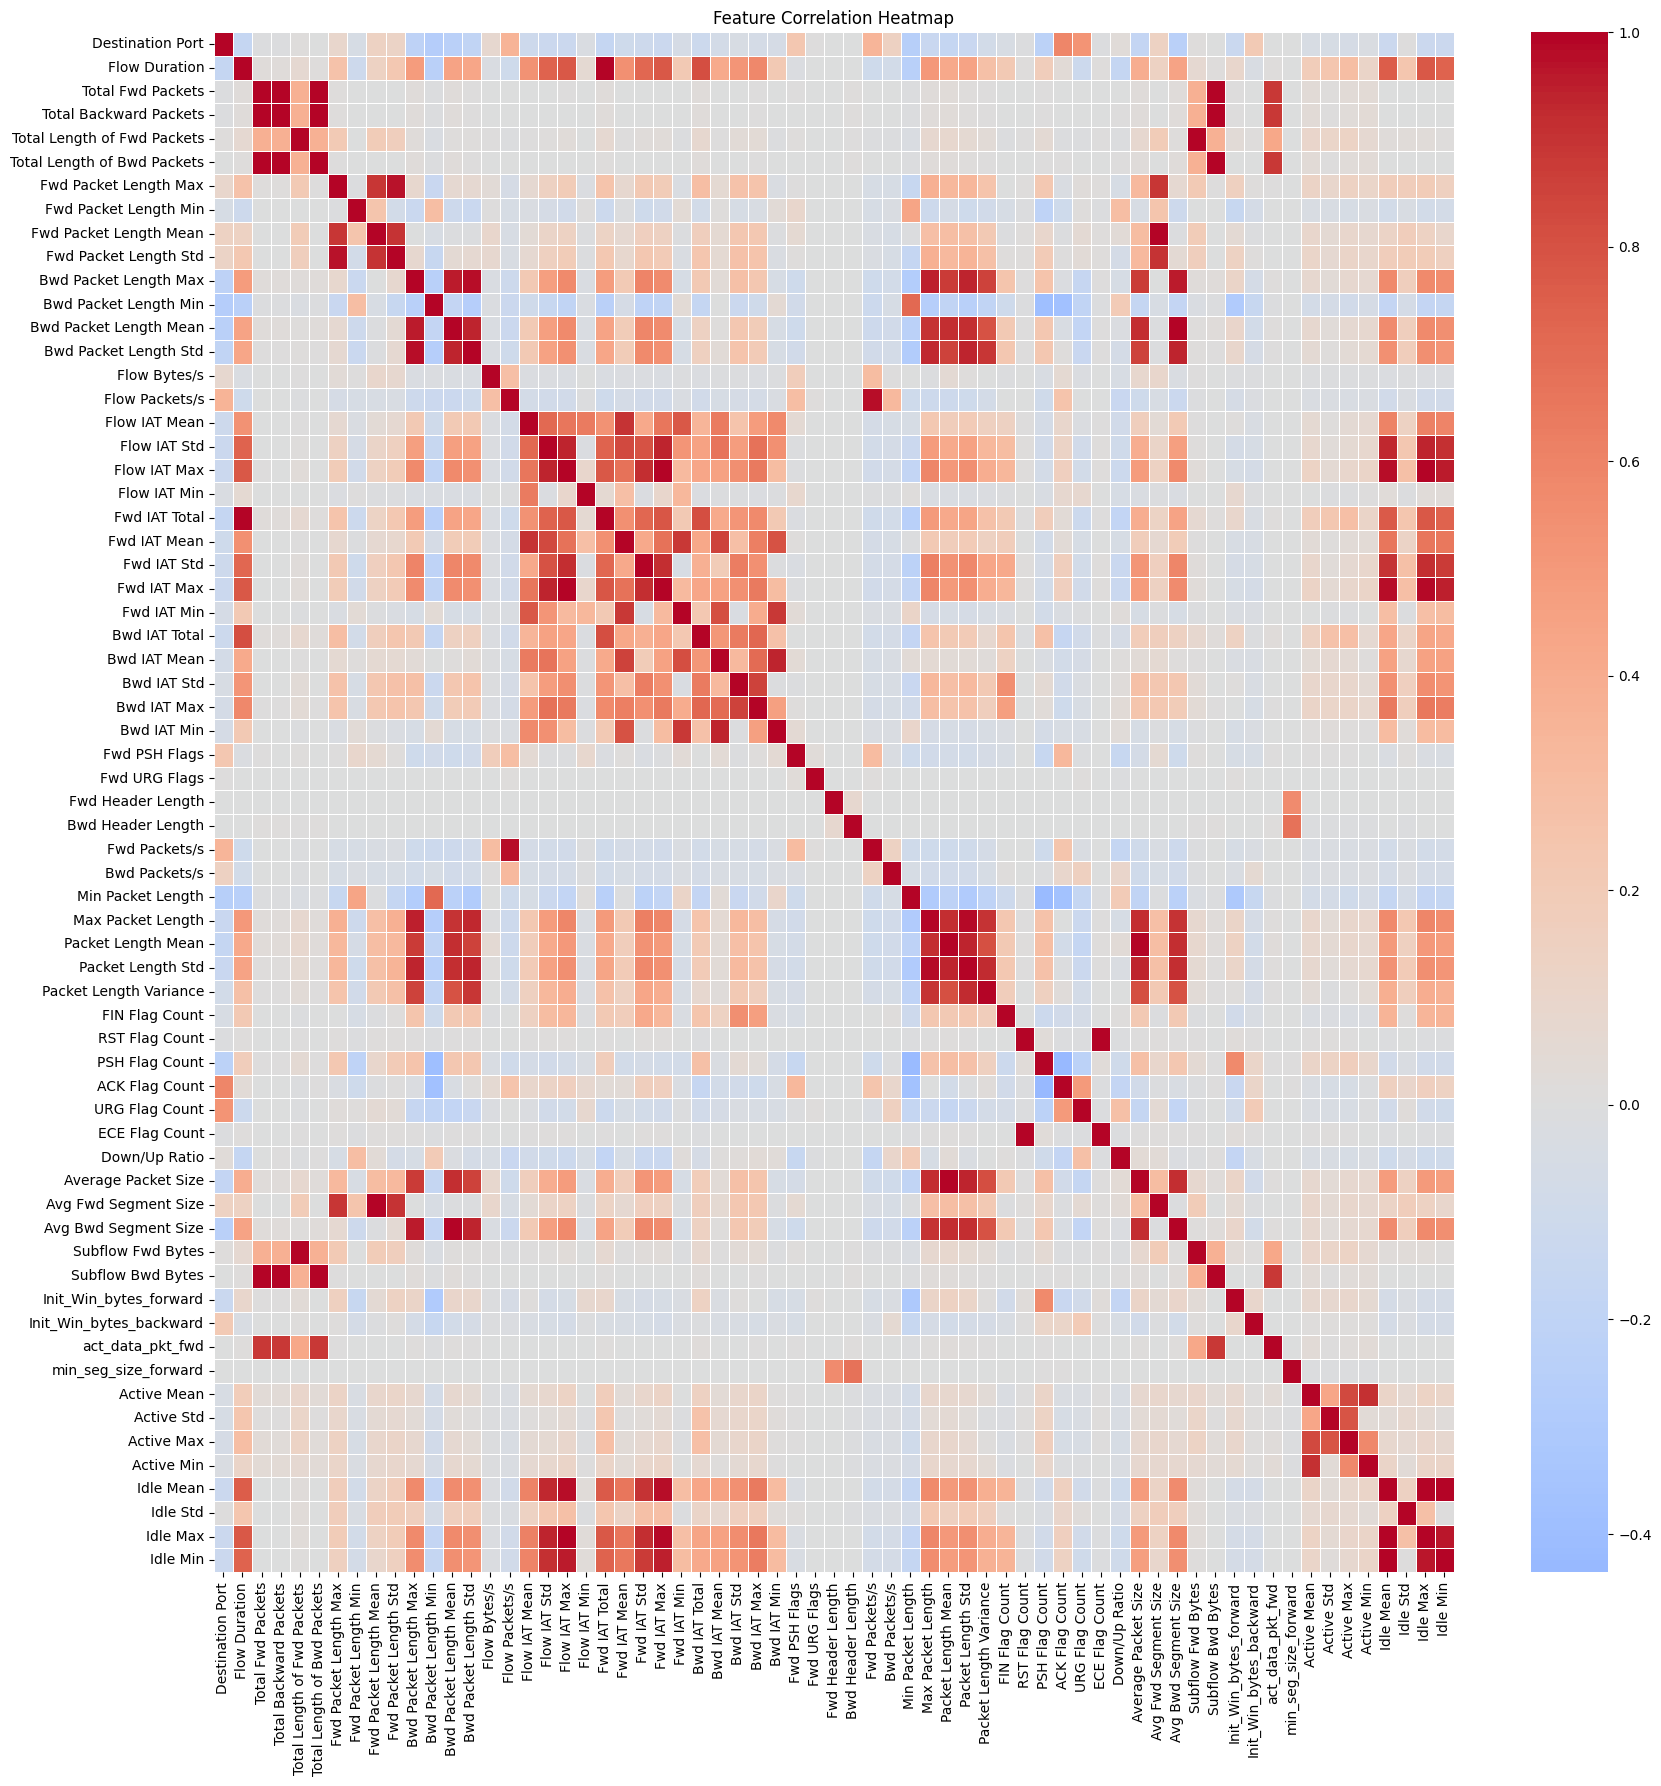

In [38]:
# Correlation Analysis:
numeric_features, categorical_features = get_feature_types(data, 'Attack Type')
high_corr = correlation_analysis(data, numeric_features)

In [39]:
# Printing the pairs with high correlation and isolating the near/perfect multicollinearity
high_multicollinearity = []
for item in high_corr:
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

Flow Duration has a high correlation with Fwd IAT Total: 0.9985
Flow Duration has a high correlation with Bwd IAT Total: 0.8199
Total Fwd Packets has a high correlation with Total Backward Packets: 0.9991
Total Fwd Packets has a high correlation with Total Length of Bwd Packets: 0.997
Total Fwd Packets has a high correlation with Subflow Bwd Bytes: 0.997
Total Fwd Packets has a high correlation with act_data_pkt_fwd: 0.8874
Total Backward Packets has a high correlation with Total Length of Bwd Packets: 0.9945
Total Backward Packets has a high correlation with Subflow Bwd Bytes: 0.9944
Total Backward Packets has a high correlation with act_data_pkt_fwd: 0.8826
Total Length of Fwd Packets has a high correlation with Subflow Fwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with Subflow Bwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with act_data_pkt_fwd: 0.884
Fwd Packet Length Max has a high correlation with Fwd Packet Length Mean: 0.889
Fwd Packet Len

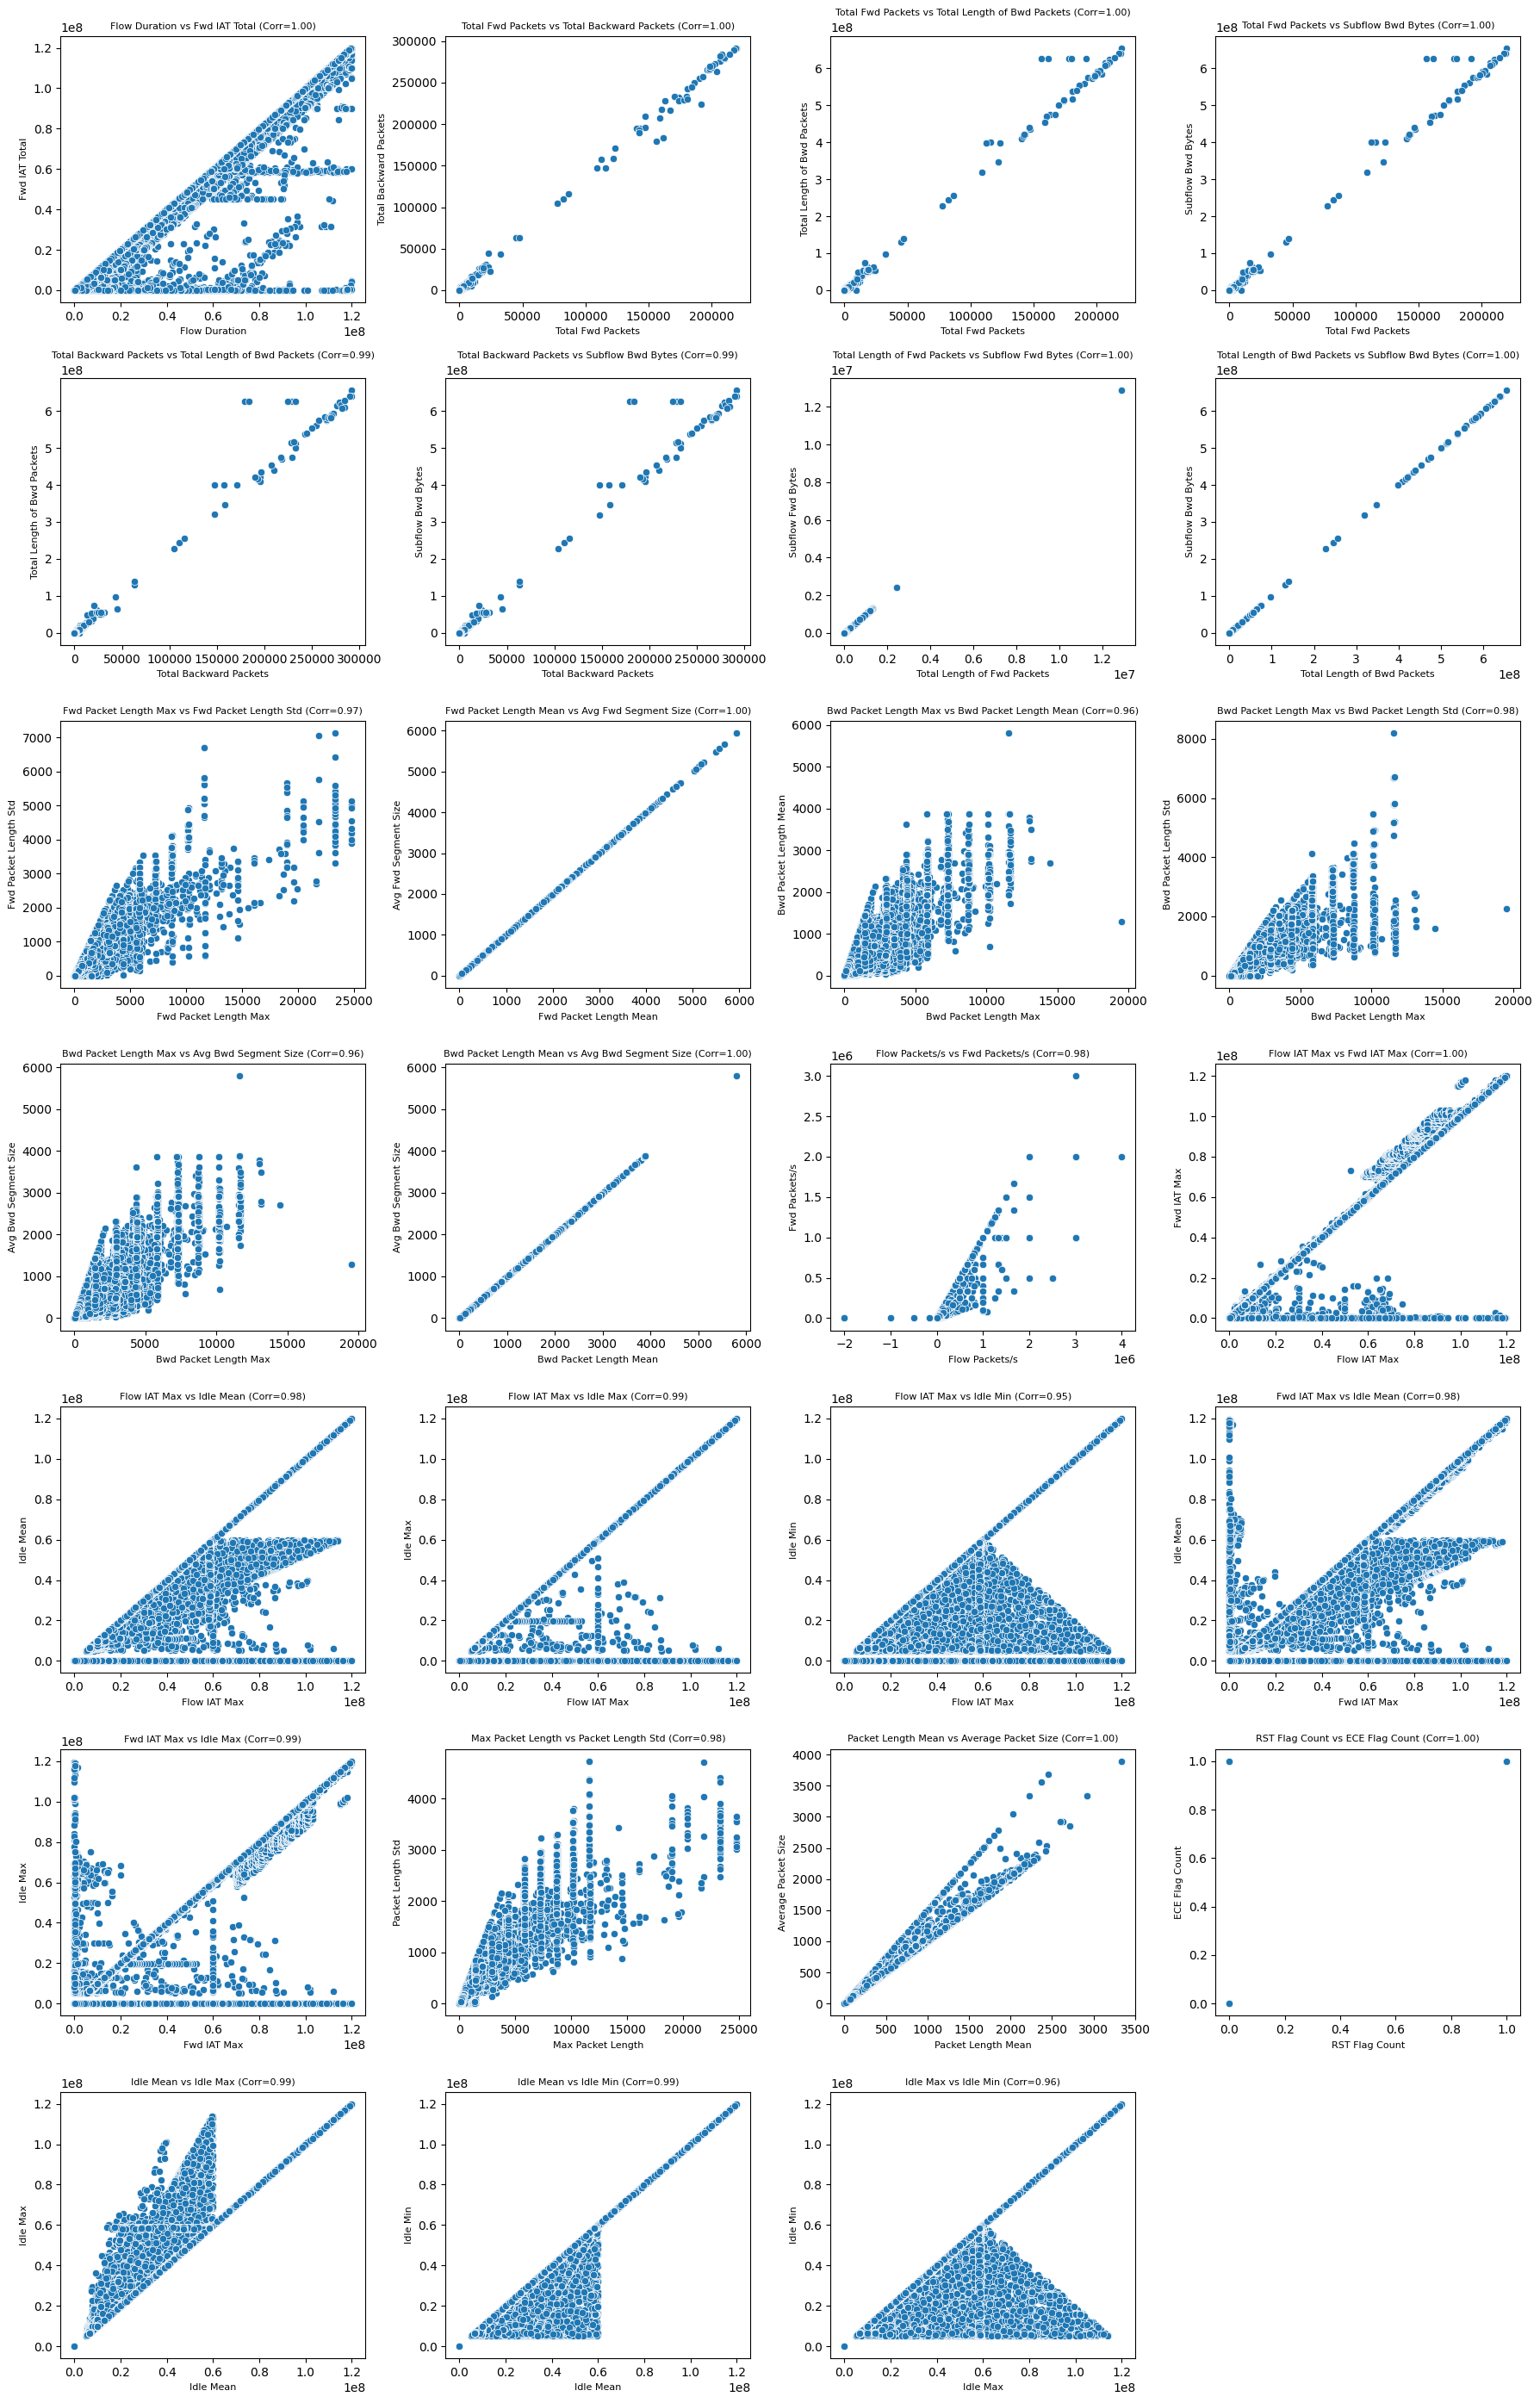

In [40]:
# Plotting the pairs with very high correlation for better visualization

n_plots = len(high_multicollinearity)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, item in enumerate(high_multicollinearity):
    feature_x = item[0]
    feature_y = item[1]
    corr_value = item[2]

    # Scatter plot
    sns.scatterplot(x=data[feature_x], y=data[feature_y], ax=axes[i])
    axes[i].set_title(f'{feature_x} vs {feature_y} (Corr={corr_value:.2f})', fontsize=8)
    axes[i].set_xlabel(feature_x, fontsize=8)
    axes[i].set_ylabel(feature_y, fontsize=8)

# Hide any unused subplots
for j in range(len(high_multicollinearity), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**By valuating the plots, we can identify some features with perfect linear correlation. Removing one instance can reduce redundancy and mitigate potential issues with multicollinearity in future models**

In [41]:
# Removal of columns based on correlation analysis
selected_columns = ['Total Backward Packets', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

# dropping columns with perfect/near perfect multicollinearity
data.drop(columns=selected_columns, inplace=True)

In [42]:
# Updating the variables and checking dataset shape
numeric_features, categorical_features = get_feature_types(data, 'Attack Type')
data.shape

(2520751, 61)

## 3.3. Outliers

**Outlier detection plays a crucial role in ensuring the quality and reliability of a dataset. Identifying features with significant deviations from the norm can help improve model accuracy by preventing skewed results.**

<Figure size 1500x1000 with 0 Axes>

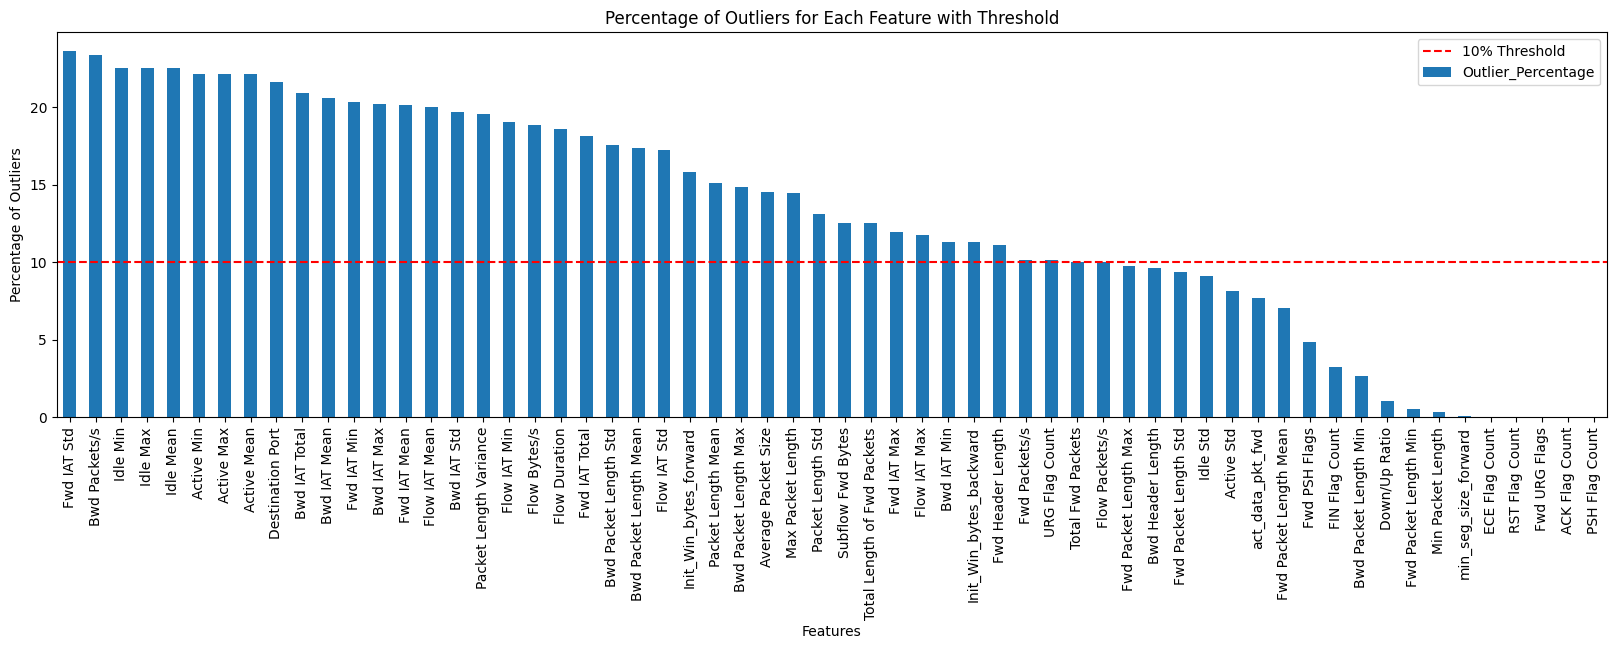

Features with outlier percentage above 10%:


In [43]:
# Calculate outliers percentage
outlier_percentages = calculate_outliers_percentage(data[numeric_features])

# Convert to DataFrame for easier manipulation
outliers_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier_Percentage'])

# Define the threshold for concern
threshold = 10  # 5% threshold for outliers

# Identify features with high percentage of outliers
high_outlier_features = outliers_df[outliers_df['Outlier_Percentage'] > threshold]

# Plot the outlier percentages and highlight features above the threshold
plt.figure(figsize=(15, 10))
outliers_df.sort_values(by='Outlier_Percentage', ascending=False).plot(kind='bar', legend=False, figsize=(20, 5))
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
plt.xlabel('Features')
plt.ylabel('Percentage of Outliers')
plt.title('Percentage of Outliers for Each Feature with Threshold')
plt.legend()
plt.show()

# Print the features with high outlier percentages
print(f"Features with outlier percentage above {threshold}%:")

In [44]:
print(high_outlier_features)

                             Outlier_Percentage
Destination Port                      21.645137
Flow Duration                         18.572124
Total Fwd Packets                     10.035303
Total Length of Fwd Packets           12.507979
Bwd Packet Length Max                 14.857556
Bwd Packet Length Mean                17.340547
Bwd Packet Length Std                 17.545922
Flow Bytes/s                          18.840576
Flow Packets/s                        10.020307
Flow IAT Mean                         19.985512
Flow IAT Std                          17.236332
Flow IAT Max                          11.751895
Flow IAT Min                          19.072649
Fwd IAT Total                         18.171926
Fwd IAT Mean                          20.126462
Fwd IAT Std                           23.657989
Fwd IAT Max                           11.925414
Fwd IAT Min                           20.366311
Bwd IAT Total                         20.926819
Bwd IAT Mean                          20

## 3.4. Data Distribution

**Understanding the distribution of the data is fundamental for selecting the right preprocessing and modeling techniques.**

In [45]:
norm_dist = 0
not_norm_dist = 0

for col in numeric_features:

    # Perform Anderson-Darling test for normality
    result = stats.anderson(data[col], dist='norm')

    # Compare the statistic with the critical value at 5% significance level
    if result.statistic < result.critical_values[2]:  # 5% significance level
        norm_dist += 1
    else:
        not_norm_dist += 1

print(f'{norm_dist} features are normally distributed')
print(f'{not_norm_dist} features are not normally distributed - Reject null hypothesis')

0 features are normally distributed
60 features are not normally distributed - Reject null hypothesis


# 4. Preprocessing

## 4.1. Feature Engineering

### 4.1.1. Feature Scaling

**Feature scaling is essential for ensuring that all features contribute equally to the model's performance, improving convergence speed, and enhancing the accuracy of machine learning algorithms, particularly those that rely on distance metrics.**

**The first step is to decide on the appropriate type of scaling. To do this, examining outliers and the distribution of features is an effective approach.**

* StandardScaler is best for normally distributed data.
* MinMaxScaler is best for bounded features.
* Robust Scaler is best when outliers are present, ensuring that the scaling maintains the robustness of the data.


| **Aspect**             | **StandardScaler**                          | **MinMaxScaler**                          | **RobustScaler**                          |  
|-----------------------|--------------------------------------------|------------------------------------------|-------------------------------------------|  
| **Scaling Approach**  | Mean and standard deviation                 | Minimum and maximum                      | Median and interquartile range            |  
| **Sensitivity to Outliers** | Sensitive (affected by outliers)       | Sensitive (max and min can distort)     | Not sensitive (robust to outliers)        |  
| **Range After Scaling** | Normal distribution (mean=0, sd=1)      | Custom range (default [0,1])            | No fixed range (median is used)           |  
| **Best For**          | Normal distributions                        | Bounded data                             | Data with outliers or non-Gaussian types  |  
| **Impact of Outliers** | Influences mean and sd                     | Influences max and min                  | Not significantly influenced                |  

**Based on the exploratory data analysis (EDA), most features exhibit a high percentage of outliers, with values exceeding 10%. As a result, Robust Scaling is likely the most appropriate preprocessing technique, as it is less sensitive to outliers compared to Standard Scaling. Additionally, statistical tests, such as the Anderson-Darling test, indicated that the null hypothesis was rejected for all of the features, confirming that the data does not follow a normal distribution**

In [46]:
scaled_df, scaler = preprocess_numerical(data, numeric_features, scaler_type='robust')
scaled_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Type
0,-0.148718,0.227972,9.75,8.11875,2.122449,-0.054054,0.624470,1.480798,1.187838,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
1,-0.148718,0.237913,9.75,8.11875,2.122449,-0.054054,0.624470,1.480798,1.187838,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
2,-0.148718,-0.009462,-0.25,-0.20625,-0.204082,-0.054054,-0.788043,0.000000,-0.131081,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
3,-0.148718,0.234938,9.75,8.31875,2.122449,-0.054054,0.658404,1.484375,1.187838,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
4,90.553846,-0.009478,-0.25,-0.20625,-0.204082,-0.054054,-0.788043,0.000000,-0.131081,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic


### 4.1.2. Class Imbalance

In [47]:
# Count occurrences of each attack type and convert to a DataFrame
attack_counts_df = scaled_df['Attack Type'].value_counts().reset_index()
attack_counts_df.columns = ['Attack Type', 'Number of Occurrences']

# Counting the total for each attack on both cases
total_occurrences = attack_counts_df['Number of Occurrences'].sum()

# Calculating the respective percentages
attack_counts_df['% of Total'] = ((attack_counts_df['Number of Occurrences'] / total_occurrences) * 100).round(2)

print(attack_counts_df)

      Attack Type  Number of Occurrences  % of Total
0  Normal Traffic                2095057       83.11
1             DoS                 193745        7.69
2            DDoS                 128014        5.08
3   Port Scanning                  90694        3.60
4     Brute Force                   9150        0.36
5     Web Attacks                   2143        0.09
6            Bots                   1948        0.08


**Class Imbalance**

The previous analysis show a clear class imbalance, which should be taken into consideration while working with the CIC-IDS-2017, as highlighted by Panigrahi and Borah (2018).

**Observations**:
1. Dominance of the 'BENIGN' class/ Normal Traffic – 83.1% of the entire dataset
2. Higher types with lower counts – Even DoS, the second most relevant class, shows low counts
3. Rare classes even after regrouping, such as Bots, Web Attacks and Brute Force

**Potential implications**:
* Model Bias: Models can become biased towards the majority class, leading to high accuracy but poor recall and precision for minority classes.
* Performance Metrics: In an imbalanced dataset, accuracy is often not a sufficient metric to evaluate model performance. F1-score, precision, recall, or ROC-AUC are better suited for assessing the model's ability to classify different classes effectively.

**Ideas to address the issue during ML training**:
* Class weights to penalize mistakes on minority classes
* Ensemble Methods can improve overall predictions (Random Forests, XGBoost)
* Cross-validation with representative folds
* Partial SMOTE to help balancing the distribution
* Undersampling the majority class

# 5. Feature Importance

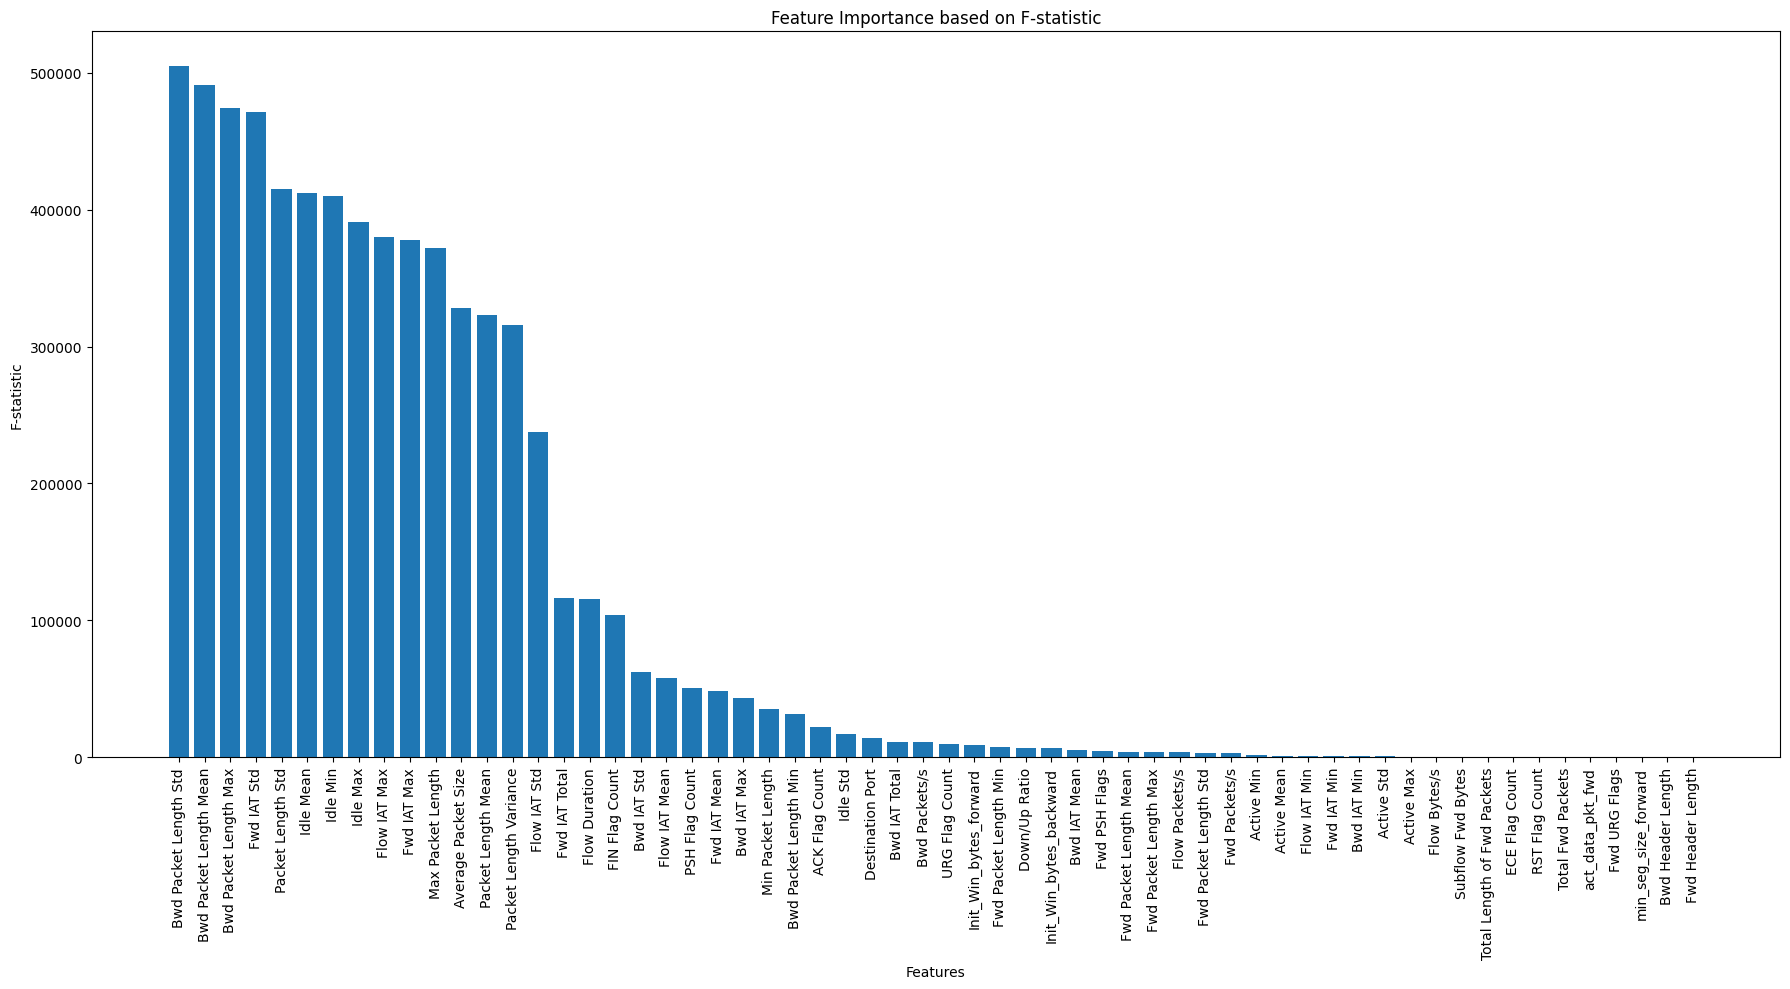

In [48]:
# Analysing feature importance using ANOVA.
f_p_stats = analyze_feature_importance(scaled_df, numeric_features)

**While ANOVA can be helpful for initial feature screening by identifying features with significantly different means across attack categories, it might not capture the full complexity of feature importance in intrusion detection due to its assumptions about data distribution and its focus on mean differences rather than other relationships.**

Test Score: 0.9987


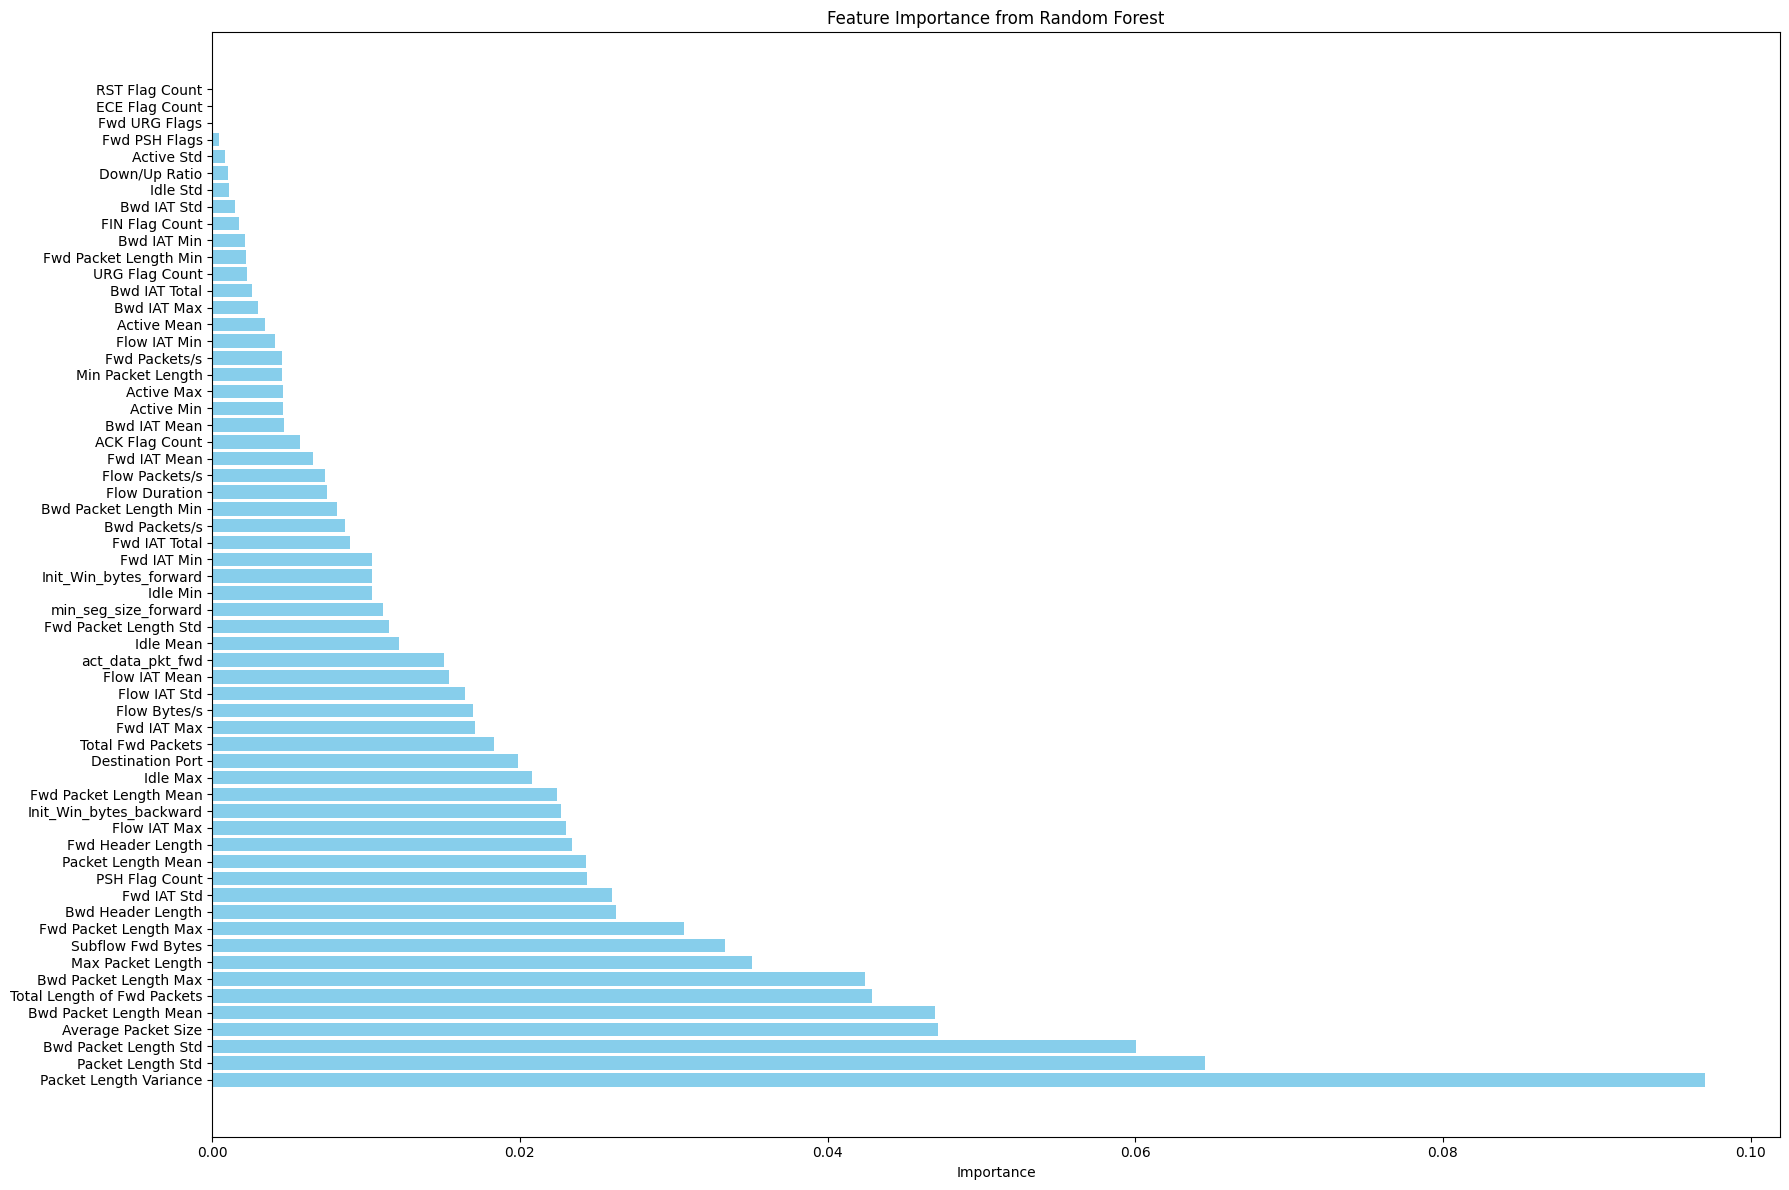

In [49]:
# Analysing feature importance using Tree-Model
feature_importance_tree = analyze_feature_importance_rf(scaled_df, numeric_features)

**Random Forests are ensemble methods that provide built-in measures of feature importance based on how much each feature contributes to reducing impurity in the trees.**

In [50]:
# Preparing the df for comparison
f_p_stats.reset_index(inplace = True)
f_p_stats.rename(columns = {'index':'Feature'}, inplace = True)

In [51]:
# Sorting the new df for easier visualization
comparison_tb = feature_importance_tree.merge(f_p_stats, on = 'Feature', how = 'left')
comparison_tb_sorted = comparison_tb.sort_values(by='Importance', ascending=False)
comparison_tb_sorted

,Feature,Importance,F-statistic,p-value
0,Packet Length Variance,9.706048e-02,315639.619177,0.000000e+00
1,Packet Length Std,6.452495e-02,414701.796166,0.000000e+00
2,Bwd Packet Length Std,6.002571e-02,504975.899469,0.000000e+00
3,Average Packet Size,4.720401e-02,328037.865590,0.000000e+00
4,Bwd Packet Length Mean,4.697824e-02,491171.644363,0.000000e+00
5,Total Length of Fwd Packets,4.287303e-02,176.822180,6.596825e-226
6,Bwd Packet Length Max,4.240585e-02,474025.334972,0.000000e+00
7,Max Packet Length,3.507538e-02,371689.725170,0.000000e+00
8,Subflow Fwd Bytes,3.334521e-02,177.340408,1.402702e-226
9,Fwd Packet Length Max,3.066459e-02,3664.800671,0.000000e+00


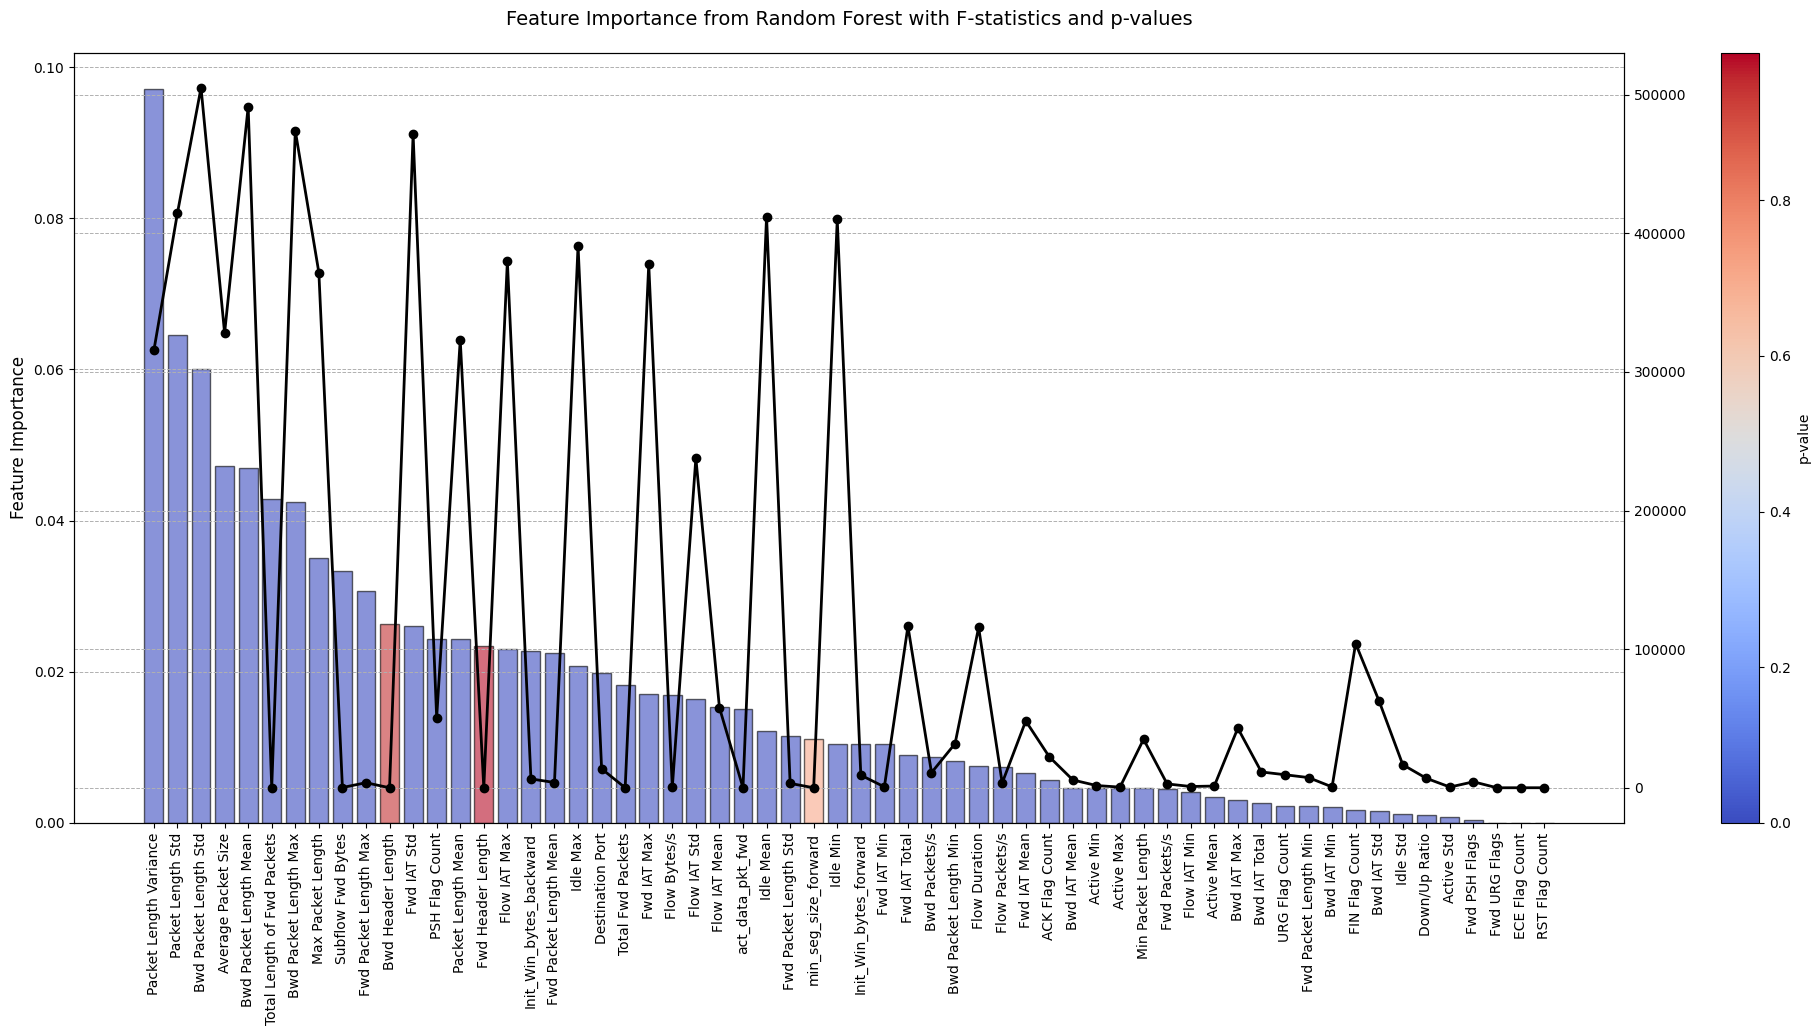

In [52]:
# Create figure and axis with appropriate size
plt.figure(figsize=(25, 10))

# Create a color map based on p-value
colors = sns.color_palette("coolwarm", as_cmap=True)

# Create twin axes for different scales
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot bars for importance
bars = ax1.bar(comparison_tb_sorted['Feature'],
                comparison_tb_sorted['Importance'],
                alpha=0.6,
                color=[colors(0 + (value)) for value in comparison_tb_sorted['p-value']], edgecolor='black')

# Plot line for F-statistic
line = ax2.plot(comparison_tb_sorted['Feature'],
                 comparison_tb_sorted['F-statistic'],
                 color='black',
                 linewidth=2,
                 label='F-statistic',
                 marker='o')

# Customize primary y-axis (Importance)
ax1.set_ylabel('Feature Importance', fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Set x-ticks and labels
ax1.set_xticks(range(len(comparison_tb_sorted['Feature'])))
ax1.set_xticklabels(comparison_tb_sorted['Feature'], rotation=90, ha='center', fontsize=10)

# Add title
plt.title('Feature Importance from Random Forest with F-statistics and p-values',
          fontsize=14, pad=20)

# Add colorbar for p-values
sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=comparison_tb_sorted['p-value'].min(), vmax=comparison_tb_sorted['p-value'].max()))
cbar = plt.colorbar(sm, ax=ax1, orientation='vertical')
cbar.set_label('p-value', fontsize=10)

# Add gridlines for readability
ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

plt.show()


In [53]:
# Isolating the features that failed the p-value test
failed_p_features = f_p_stats[f_p_stats['p-value'] > 0.5]['Feature'].tolist()

print('The chart above facilitates to visualize that the features:\n')
for feature in failed_p_features:
    print(feature)
print('\nfail the p-value test, although selected by the Random Forest algorithm')

The chart above facilitates to visualize that the features:

min_seg_size_forward
Bwd Header Length
Fwd Header Length

fail the p-value test, although selected by the Random Forest algorithm


**The plot illustrates that while some features selected by the Random Forest (RF) have lower F-statistics, the most significant features are found within the range where the highest F-statistic values are concentrated. When training the machine learning models, it may be beneficial to remove certain features based on these results, such as those that did not pass the p-value test, and retest the model.**

# 6. Outputs

In [54]:
# Clean dataset to a CSV file
data.to_csv('data.csv', index=False)

# Scaled dataset to a CSV file
scaled_df.to_csv('scaled_df.csv', index=False)

# References

Iman Sharafaldin, Arash Habibi Lashkari, and Ali A. Ghorbani, “Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization”, 4th International Conference on Information Systems Security and Privacy (ICISSP), Portugal, January 2018.

Panigrahi, R.; Borah, S. 2018. A detailed analysis of CICIDS2017 dataset for designing intrusion detection systems. International Journal of Engineering & Technology 7(3.24): 479-482.